In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

##### load data

In [2]:
with open("./data/zhengqi_train.txt")  as file:
    train=pd.read_table(file, sep="\t")
with open("./data/zhengqi_test.txt") as file:
    test=pd.read_table(file, sep="\t")

##### drop bad matchness distribution columns

In [3]:
target = train.target
train.drop(["target"], axis=1, inplace=True)
train.drop(["V5","V9","V11","V17","V22","V28"], axis=1, inplace=True)
test.drop(["V5","V9","V11","V17","V22","V28"], axis=1, inplace=True)

##### samples scatter

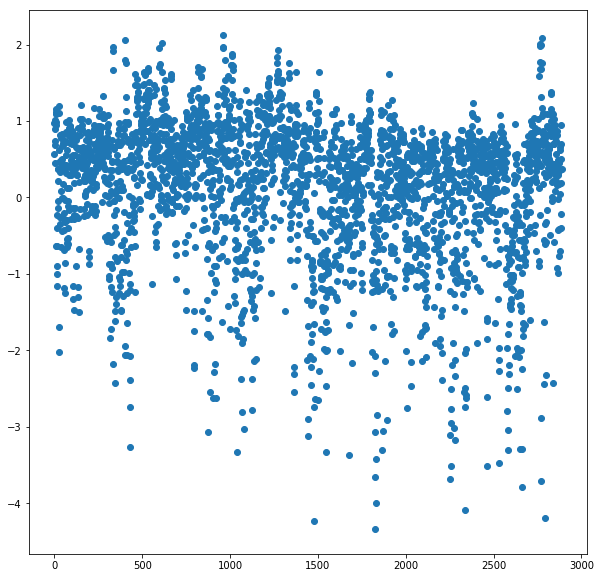

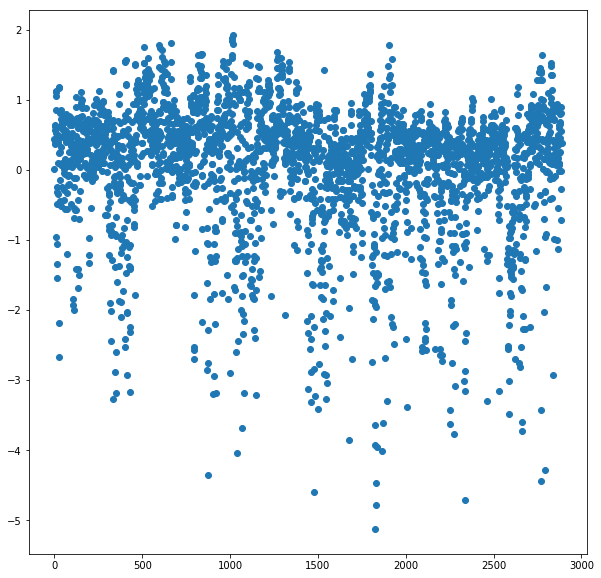

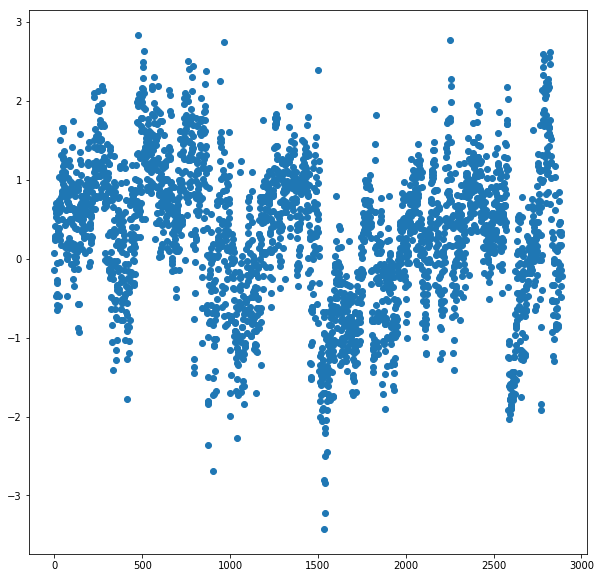

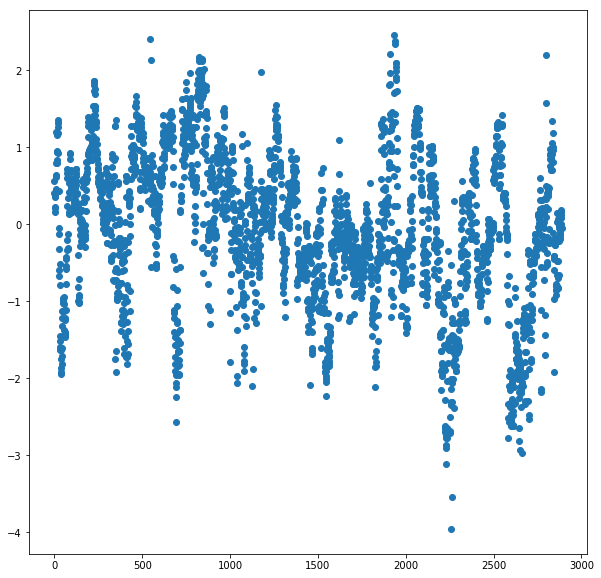

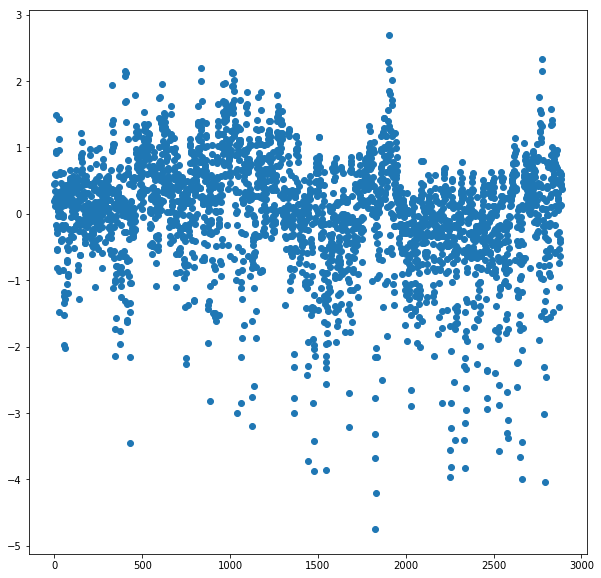

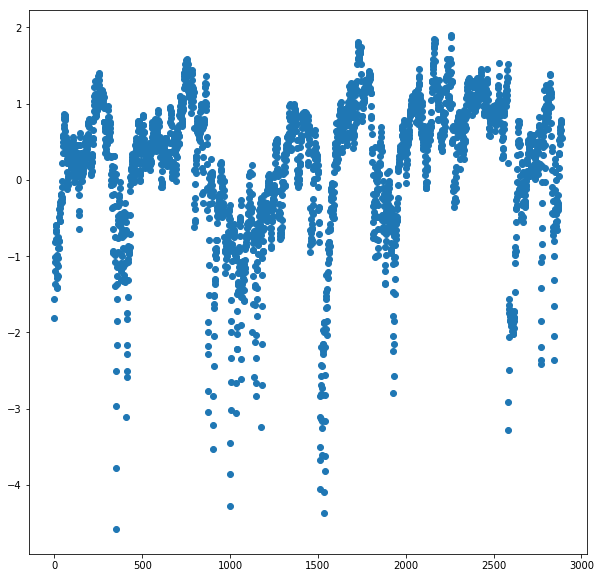

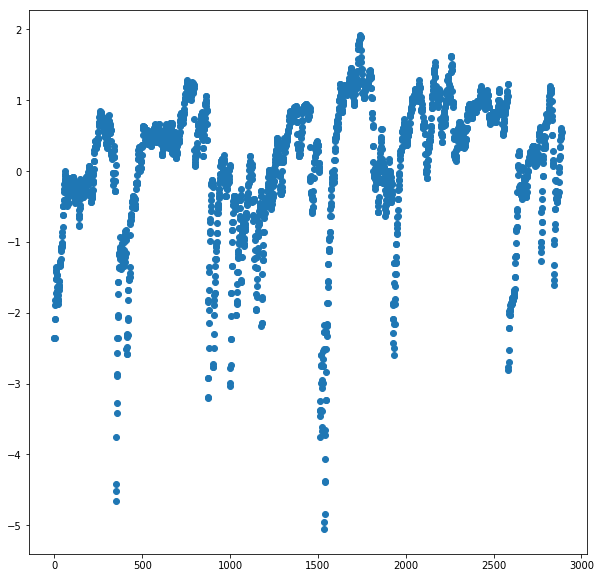

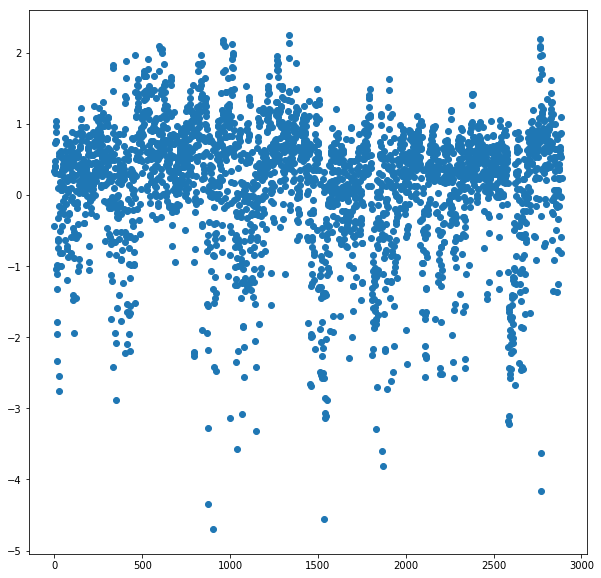

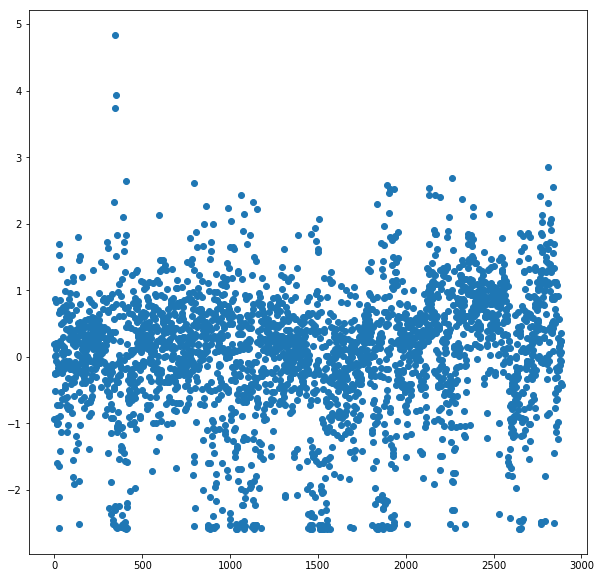

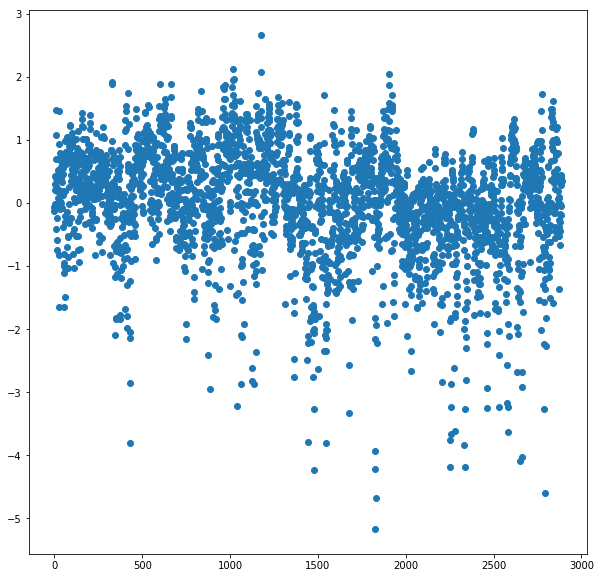

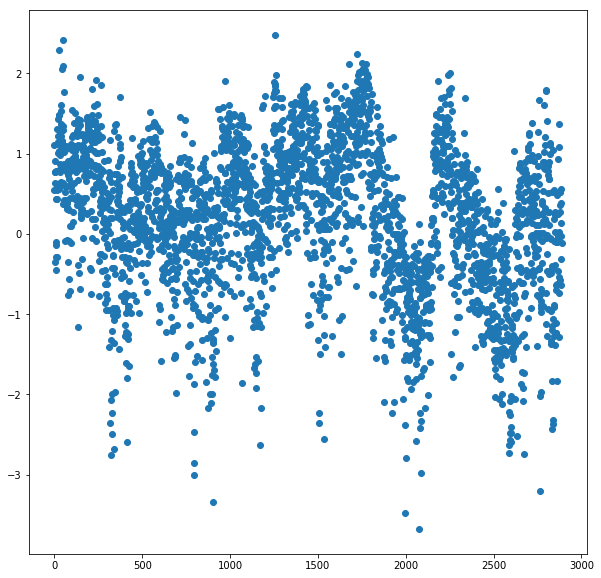

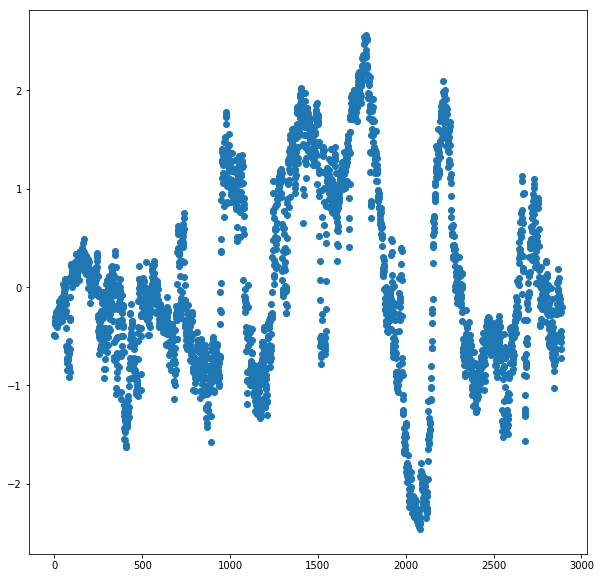

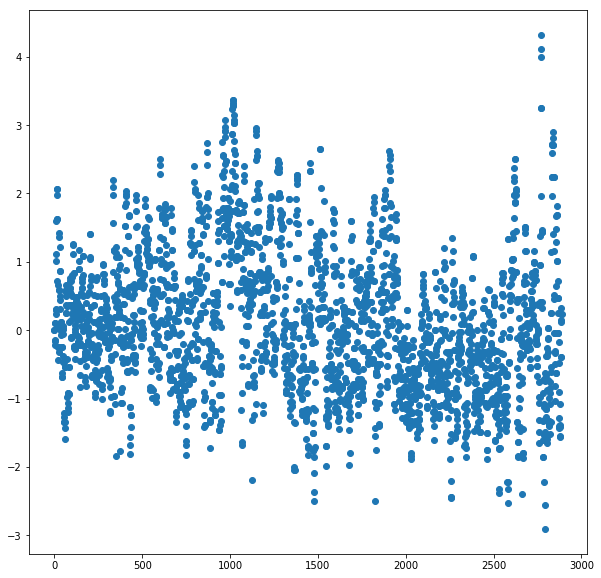

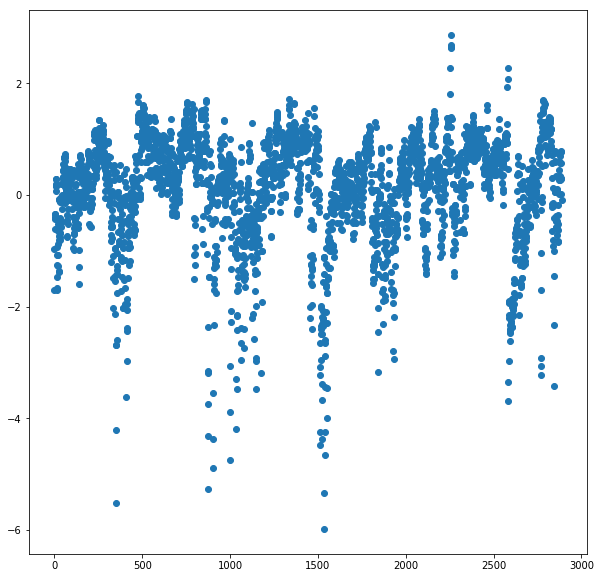

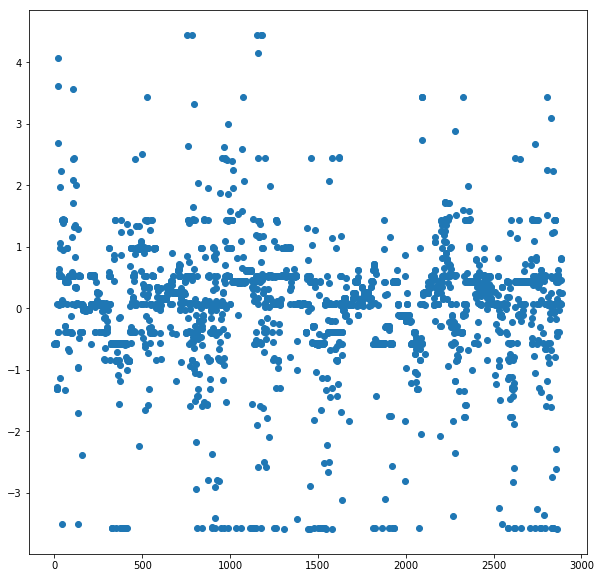

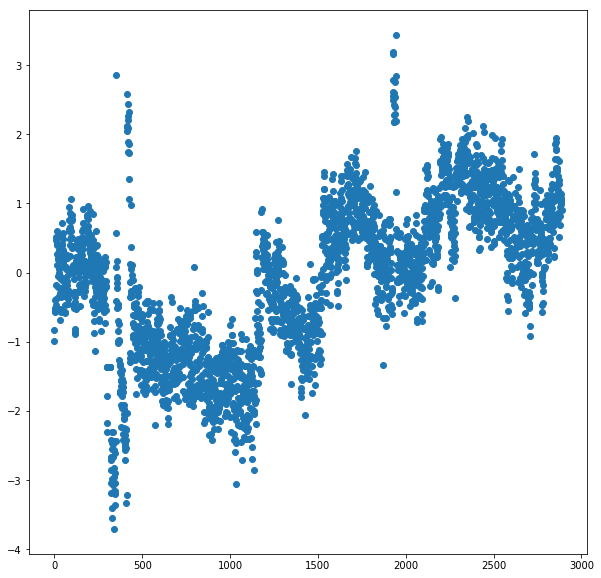

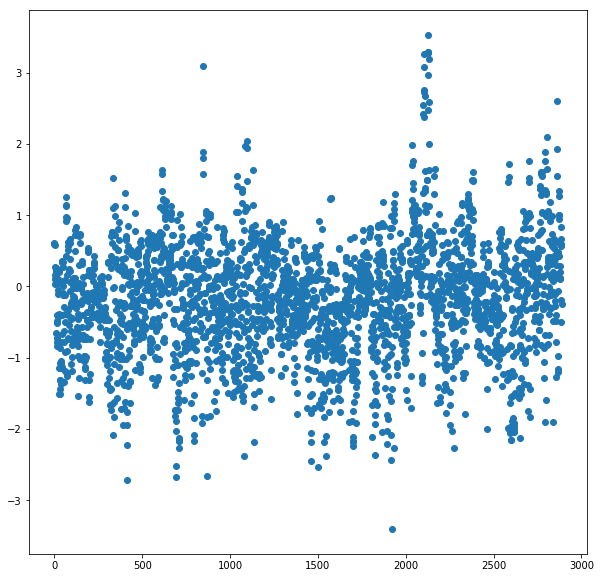

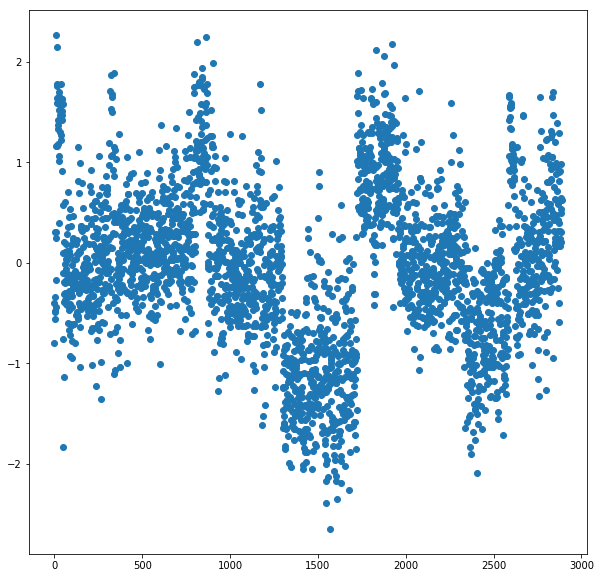

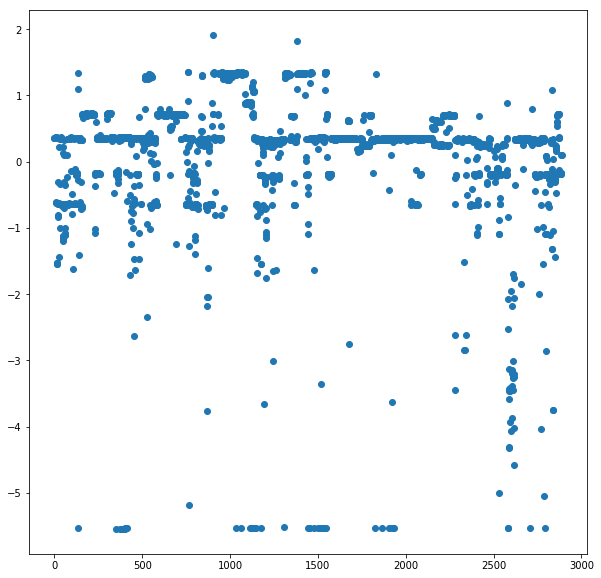

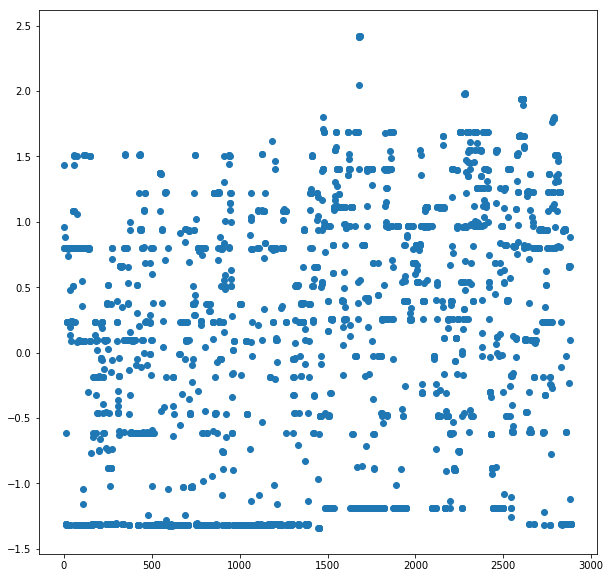

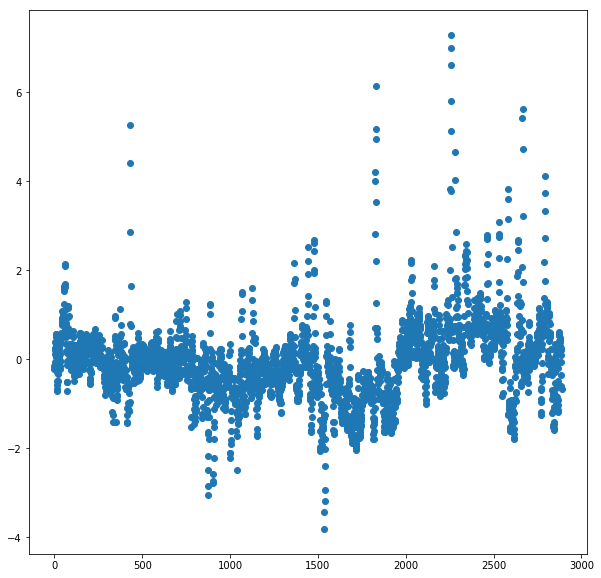

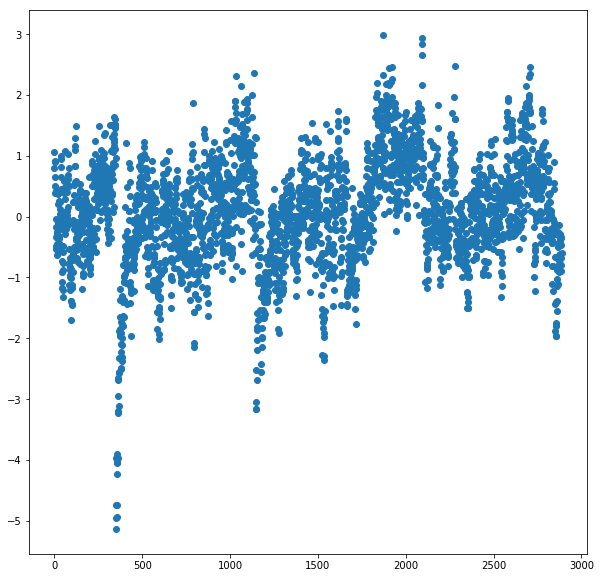

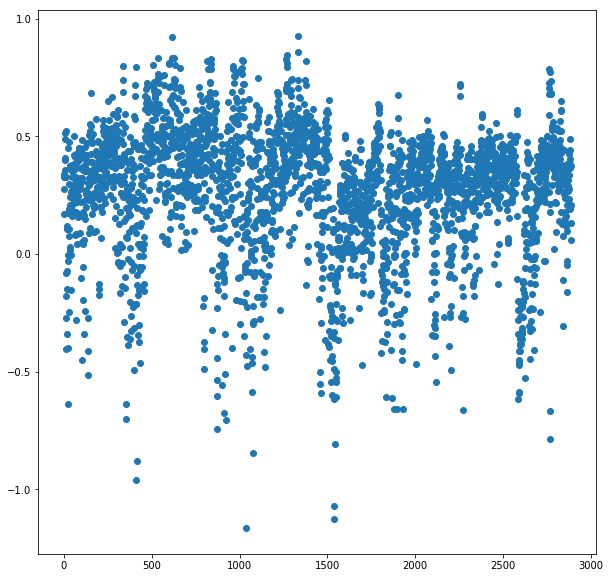

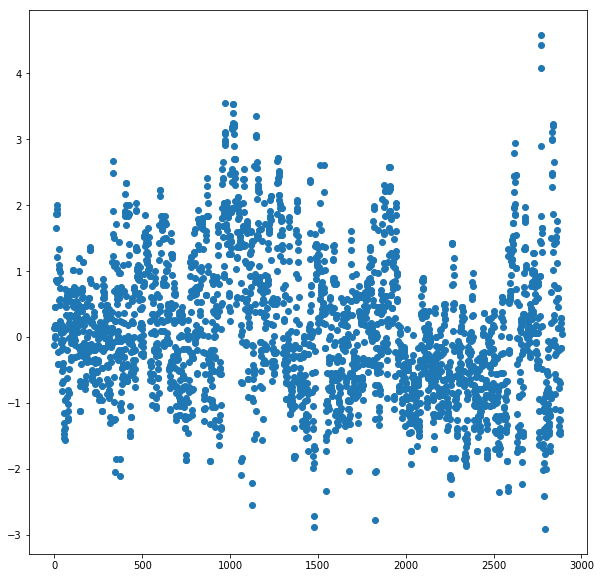

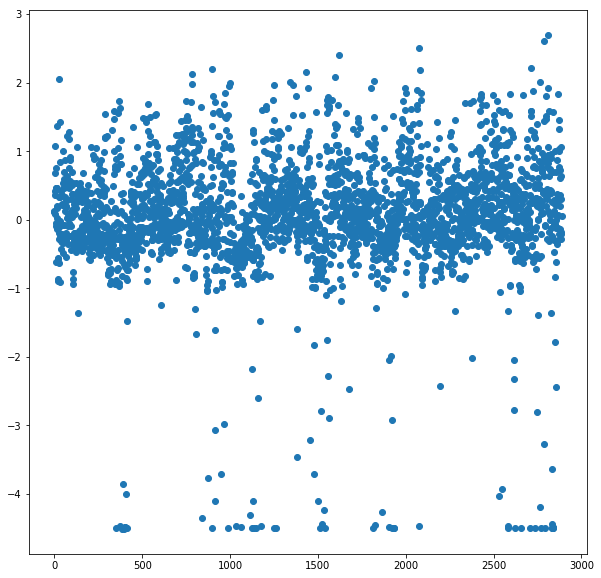

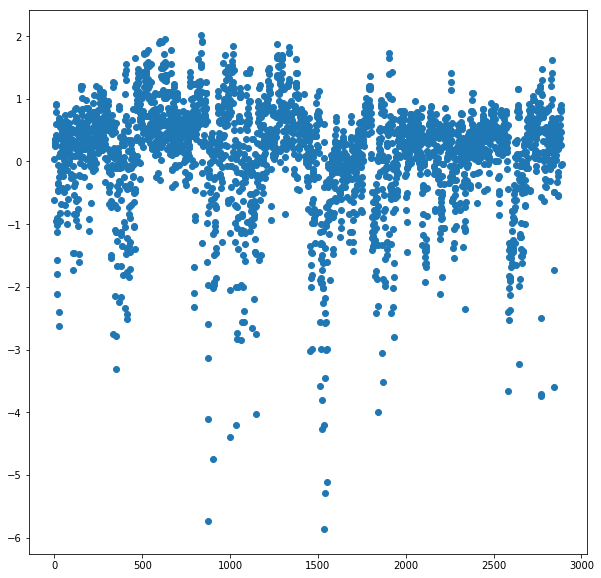

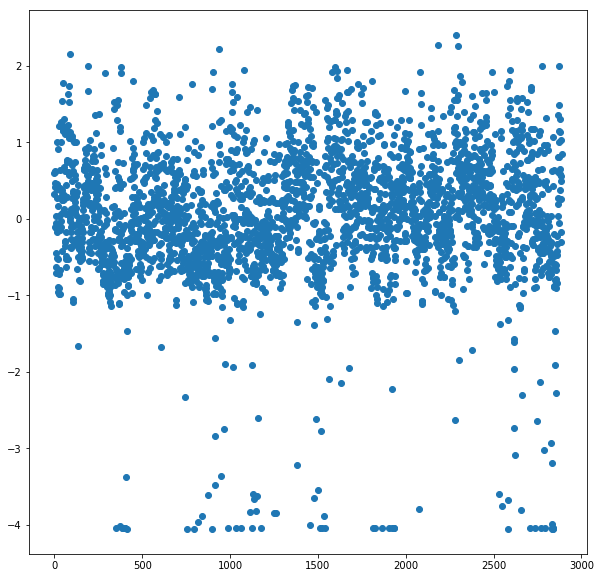

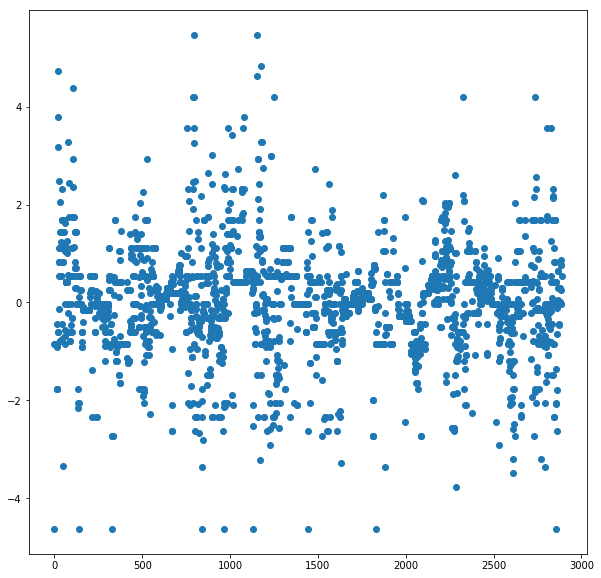

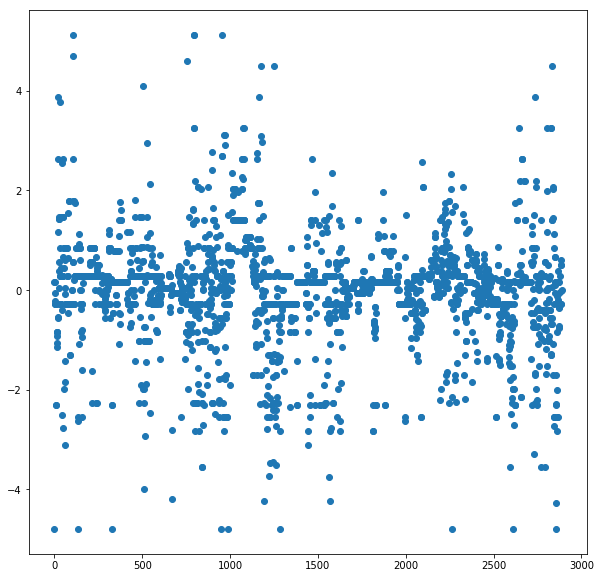

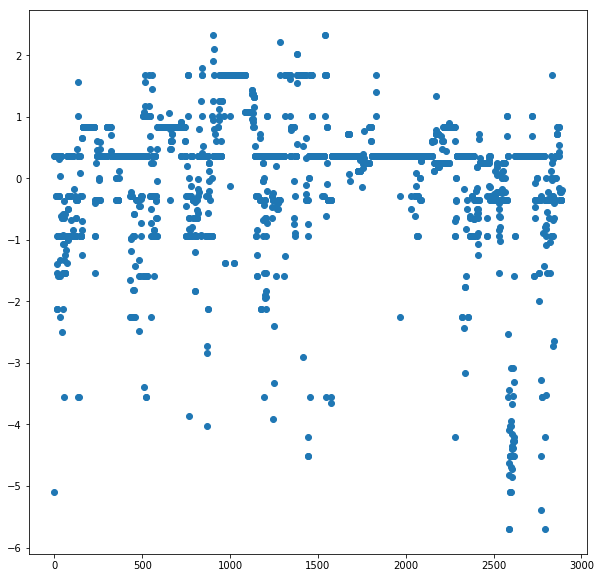

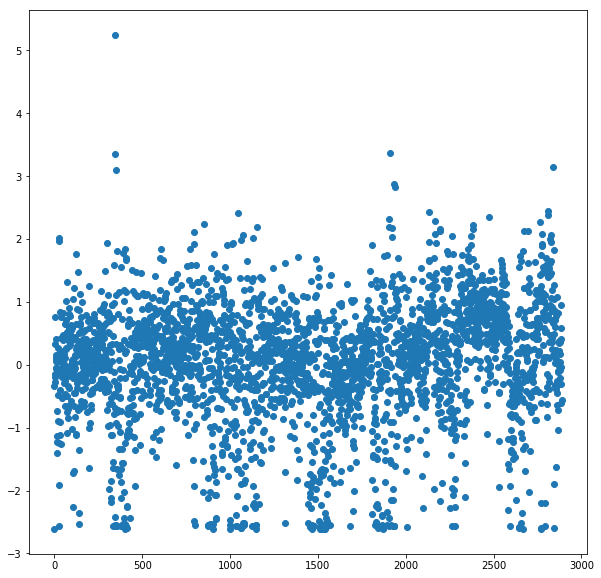

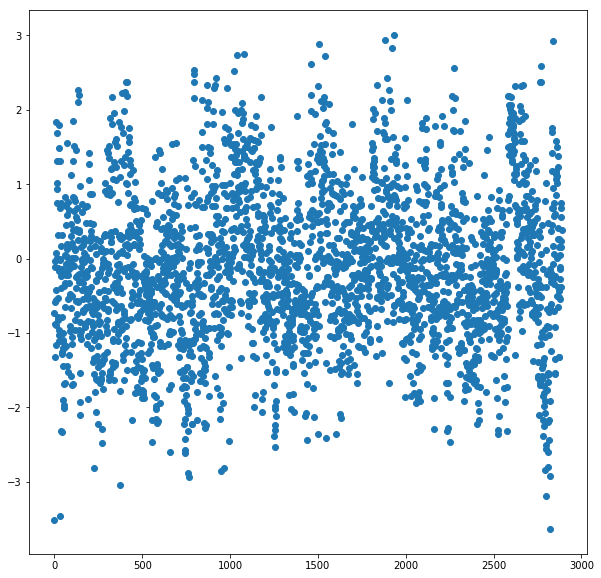

In [12]:
for i in train.columns:
    fig = plt.figure(figsize=(10,10))
    plt.scatter(train.index, train[i])
    plt.show()

##### Standarization

In [4]:
data_all = pd.concat([train,test])

In [5]:
std_scale = StandardScaler()
data_std = std_scale.fit_transform(data_all)

In [6]:
train_std = pd.DataFrame(data_std[:train.shape[0]], columns=train.columns)
test_std = pd.DataFrame(data_std[train.shape[0]:], columns=test.columns)

##### drop non-corr columns with target

In [15]:
corr = pd.DataFrame(train_std).corrwith(pd.Series(target))
selected = corr[abs(corr)>0.1]
train_std_corr = pd.DataFrame(train_std)[selected.index]
test_std_corr = std = pd.DataFrame(test_std)[selected.index]

In [20]:
train_std_corr.shape

(2888, 25)

##### select k-best with  f_regression

In [22]:
from sklearn.feature_selection import SelectKBest, chi2,f_classif,f_regression,mutual_info_,mutual_info_classif,mutual_info_regression,rfe

In [31]:
sele_k = SelectKBest(score_func=f_regression, k= 20)

In [32]:
train_std_corr_f_reg = sele_k.fit_transform(train_std_corr, target)
test_std_corr_f_reg = sele_k.transform(test_std_corr)

In [49]:
test_std_corr_f_reg

array([[ 0.36795383,  0.37995164, -0.22497915, ..., -0.04200047,
        -0.5669382 ,  0.3879511 ],
       [ 0.14793373,  0.48896125, -0.24698128, ...,  0.17602247,
        -0.29391503,  0.10392636],
       [-0.16609496, -0.06208734, -0.31098746, ...,  0.19902489,
         0.37314158,  0.56896687],
       ...,
       [-2.61531873, -3.56439613, -3.4022862 , ..., -6.11163922,
        -2.54410599,  1.61205774],
       [-2.66132294, -3.64640336, -3.27127354, ..., -5.2685505 ,
        -2.54910642,  1.43104197],
       [-2.32129187, -3.03734966, -3.21426803, ..., -5.2115445 ,
        -1.12298539,  1.9880905 ]])

In [50]:
from sklearn.decomposition import PCA, KernelPCA

In [62]:
pca = PCA(n_components=0.95).fit(train_std_corr_f_reg)

In [63]:
train_std_corr_f_reg_pca = pca.transform(train_std_corr_f_reg)
test_std_corr_f_reg_pca = pca.transform(test_std_corr_f_reg)

In [65]:
train_std_corr_f_reg_pca = pd.DataFrame(train_std_corr_f_reg_pca, columns=["col_{}".format(i) for i in range(train_std_corr_f_reg_pca.shape[1]) ])
test_std_corr_f_reg_pca = pd.DataFrame(test_std_corr_f_reg_pca, columns=["col_{}".format(i) for i in range(test_std_corr_f_reg_pca.shape[1]) ])

##### models predict

In [7]:
from sklearn.svm import SVR

In [4]:
params_test1 = {"alpha": np.arange(0,10,0.05)}

In [5]:
model_ridge = Ridge(copy_X =True, normalize=True)

In [6]:
gsearch = GridSearchCV(estimator=model_ridge, param_grid=params_test1, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
gsearch.fit(train, target)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': array([0.  , 0.05, ..., 9.9 , 9.95])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [7]:
gsearch.best_params_

{'alpha': 0.0}

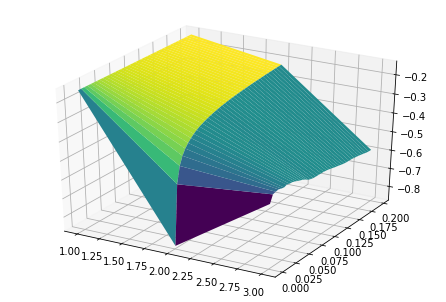

In [85]:
x = ["linear","rbf", "poly"]
y = np.arange(0.001,0.2,0.005)
X, Y = np.meshgrid(x, y)
Z = gsearch.cv_results_["mean_test_score"].reshape((len(y), len(x)))

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis)

plt.show()

In [5]:
model = Lasso(copy_X =True, normalize=True)

In [6]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
result_val = np.zeros(shape=(len(train),))
result_test = np.zeros(shape=(len(test),))
for i, (tr_index, val_index) in enumerate(kf.split(train, target)):
    tr_X, val_X = train.iloc[tr_index,:], train.iloc[val_index,:]
    tr_y, val_y = target[tr_index], target[val_index]
    model.fit(X=tr_X, y=tr_y)
    pred_val_y = model.predict(val_X)
    mse = mean_squared_error(y_pred=pred_val_y, y_true=val_y)
    print("mse:", mse)
    result_val[val_index] = pred_val_y
    pred_test = model.predict(test)
    result_test += pred_test
result_test /=5

mse: 0.09626468391443854
mse: 0.11266362290921816
mse: 0.14150990301266703
mse: 0.10564298149758135
mse: 0.1087897274934472


standarize--linearRegression
mse: 0.09626468391443853
mse: 0.11266362290921816
mse: 0.14150990301266694
mse: 0.10564298149758145
mse: 0.10878972749344719

standarize--linearRegression--drop5fea
mse: 0.09813509776520422
mse: 0.11468568694623027
mse: 0.14562718310670678
mse: 0.10658209696226145
mse: 0.11470404327911429

standarize-linearSVR linear c=0.32---best one
[LibSVM]mse: 0.0956052503581263
[LibSVM]mse: 0.11192394889063702
[LibSVM]mse: 0.14319144270403586
[LibSVM]mse: 0.10635886781298538
[LibSVM]mse: 0.10889718023056148

no preprocess-linearSVR c=0.32
[LibSVM]mse: 0.10125360791751475
[LibSVM]mse: 0.11922619224871157
[LibSVM]mse: 0.14621446971442253
[LibSVM]mse: 0.11373864297067933
[LibSVM]mse: 0.11446756927223932

no preprocess-linearSVR
[LibSVM]mse: 0.10124166769059915
[LibSVM]mse: 0.11937025287702223
[LibSVM]mse: 0.1463381780352651
[LibSVM]mse: 0.11327740135606693
[LibSVM]mse: 0.11464533951852822

[LibSVM]mse: 0.13147356653115358
[LibSVM]mse: 0.1398642700252353
[LibSVM]mse: 0.15122307479901317
[LibSVM]mse: 0.1362126192873151
[LibSVM]mse: 0.13649792540842148

[LibSVM]mse: 0.1320706666281539
[LibSVM]mse: 0.13958672721525262
[LibSVM]mse: 0.15143920191161483
[LibSVM]mse: 0.13597732491222303
[LibSVM]mse: 0.13631215219043835

lgb_allfea
0.09727406226146033
0.10357836453705174
0.1429707102631734
0.09946906658477907
0.10679813762914704

In [109]:
with open("./data/results/submit_gridsearch_bst.txt", "w", encoding='utf8') as file:
    for i in pred_test:
        file.write(str(i)+"\n")
    file.close()